In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import copy
# custom imports
import utils
import mcts
import train
from rtfm import featurizer as X

Using device cpu
Using device cpu


# Experiments PV-MCTS (31/05) 

Explored the combinations of 3 things:
- argmax vs softmax of Q values as the policy for choosing the action based on the root node Q values estimated during the PV-MCTS;
- entropy bonus (with weight $10^{-2}$) added to the policy loss (i.e. $-hH[\pi]$);
- sampled action or full distribution in computing the cross entropy.

In [2]:
# Load all dictionaries of the experiments
load_dir = "./save_dir"
exp_IDs = [
    "IPUX",
    "RZAP",
    "BHTY",
    "LJXR",
    "XSAN",
    "EVGU" 
          ]

checkpoint = "4000"
list_of_exp_dictionaries = []
for ID in exp_IDs:
    print("%s/%s/training_dict_%s"%(load_dir, ID, checkpoint))
    d = torch.load("%s/%s/training_dict_%s"%(load_dir, ID, checkpoint), map_location=torch.device('cpu'))
    list_of_exp_dictionaries.append(d)

./save_dir/IPUX/training_dict_4000
./save_dir/RZAP/training_dict_4000
./save_dir/BHTY/training_dict_4000
./save_dir/LJXR/training_dict_4000
./save_dir/XSAN/training_dict_4000
./save_dir/EVGU/training_dict_4000


In [3]:
# Print all keys of the first experiment dictionary
print(list_of_exp_dictionaries[0].keys())

dict_keys(['episodes_played', 'training_params', 'object_ids', 'pv_net', 'target', 'losses', 'policy_losses', 'value_losses', 'total_rewards', 'accuracies', 'entropies', 'optimizer'])


In [4]:
flags = utils.Flags(env="rtfm:groups_simple_stationary-v0")
gym_env = utils.create_env(flags)
featurizer = X.Render()
game_simulator = mcts.FullTrueSimulator(gym_env, featurizer)
object_ids = utils.get_object_ids_dict(game_simulator)

In [5]:
# Compute average and standard deviation of the total reward in 32 steps (same as the experiements)
# for the optimal policy
rewards = []
episode_length = 32
for i in range(1000):
    render = False
    if i < 10:
        print("-"*40)
        print("Episode %d"%(i+1))
        render=True
    total_reward = utils.play_episode_optimal_policy(game_simulator, episode_length, object_ids, render=render, reset_if_done=True)
    if render:
        print("Final score: ", total_reward, "\n")
    rewards.append(total_reward)
print("\nAverage reward in %d steps: %.2f"%(episode_length, np.mean(rewards)))
optimal_reward_mean = np.mean(rewards)
optimal_reward_std = np.std(rewards)

----------------------------------------
Episode 1

██████
█n   █
█    █
█ !@ █
█?y  █
██████

Best actions:  ['Down']

██████
█n   █
█    █
█ !  █
█?y@ █
██████

Best actions:  ['Left']

██████
█n   █
█    █
█ !  █
█?@  █
██████
blessed sword
Best actions:  ['Up']

██████
█n   █
█    █
█ @  █
█?   █
██████
blessed sword
Best actions:  ['Up', 'Right']

██████
█    █
█ y  █
█ @? █
█n!  █
██████

Best actions:  ['Up']

██████
█    █
█ @  █
█  ? █
█n!  █
██████
blessed sword
Best actions:  ['Down']

██████
█    █
█    █
█ @? █
█n!  █
██████
blessed sword
Best actions:  ['Down']

██████
█    █
█    █
█  ? █
█n@  █
██████
blessed sword
Best actions:  ['Down']

██████
█    █
█ @! █
█   n█
█ ?y █
██████

Best actions:  ['Down']

██████
█    █
█  ! █
█ @ n█
█ ?y █
██████

Best actions:  ['Right']

██████
█    █
█  ! █
█  @n█
█ ?y █
██████

Best actions:  ['Down']

██████
█    █
█  ! █
█   n█
█ ?@ █
██████
blessed sword
Best actions:  ['Up']

██████
█    █
█  ! █
█  @n█
█ ?  █
██████
blessed sw

Best actions:  ['Stay']

██████
█@ ?!█
█  n █
█    █
█    █
██████
blessed sword
Best actions:  ['Stay']

██████
█@ ?!█
█  n █
█    █
█    █
██████
blessed sword
Best actions:  ['Stay']

██████
█@ ?!█
█  n █
█    █
█    █
██████
blessed sword
Best actions:  ['Stay']

██████
█@ ?!█
█  n █
█    █
█    █
██████
blessed sword
Best actions:  ['Stay']

██████
█@ ?!█
█  n █
█    █
█    █
██████
blessed sword
Best actions:  ['Stay']

██████
█@ ?!█
█  n █
█    █
█    █
██████
blessed sword
Best actions:  ['Stay']

██████
█@ ?!█
█  n █
█    █
█    █
██████
blessed sword
Best actions:  ['Stay']

██████
█@ ?!█
█  n █
█    █
█    █
██████
blessed sword
Best actions:  ['Stay']

██████
█@ ?!█
█  n █
█    █
█    █
██████
blessed sword
Best actions:  ['Stay']

██████
█@ ?!█
█  n █
█    █
█    █
██████
blessed sword
Best actions:  ['Stay']

██████
█@ ?!█
█  n █
█    █
█    █
██████
blessed sword
Best actions:  ['Stay']

██████
█@ ?!█
█  n █
█    █
█    █
██████
blessed sword
Best actions:  ['Stay']

███

Best actions:  ['Left']

██████
█n   █
█    █
█ @ !█
█   ?█
██████
blessed sword
Best actions:  ['Right']

██████
█n   █
█    █
█  @!█
█   ?█
██████
blessed sword
Best actions:  ['Right']

██████
█n   █
█    █
█   @█
█   ?█
██████
blessed sword
Best actions:  ['Left', 'Down']

██████
█n   █
█ !  █
█   ?█
█ y@ █
██████

Best actions:  ['Left']

██████
█n   █
█ !  █
█   ?█
█ @  █
██████
blessed sword
Best actions:  ['Up']

██████
█n   █
█ !  █
█ @ ?█
█    █
██████
blessed sword
Best actions:  ['Up']

██████
█n   █
█ @  █
█   ?█
█    █
██████
blessed sword
Best actions:  ['Up', 'Left']

██████
█? n █
█y ! █
█   @█
█    █
██████

Best actions:  ['Left']

██████
█? n █
█y ! █
█  @ █
█    █
██████

Best actions:  ['Left']

██████
█? n █
█y ! █
█ @  █
█    █
██████

Best actions:  ['Up', 'Left']

██████
█? n █
█y ! █
█@   █
█    █
██████

Best actions:  ['Up']

██████
█? n █
█@ ! █
█    █
█    █
██████
blessed sword
Best actions:  ['Right']

██████
█? n █
█ @! █
█    █
█    █
██████
blessed s

Best actions:  ['Up']

██████
█   ?█
█  !@█
█    █
█    █
██████
blessed sword
Best actions:  ['Left']

██████
█   ?█
█  @ █
█    █
█    █
██████
blessed sword
Best actions:  ['Right']

██████
█  !y█
█  ?n█
█  @ █
█    █
██████

Best actions:  ['Right']

██████
█  !y█
█  ?n█
█   @█
█    █
██████

Best actions:  ['Up']

██████
█  !y█
█  ?@█
█    █
█    █
██████
gleaming sword
Best actions:  ['Up']

██████
█  !@█
█  ? █
█    █
█    █
██████
blessed sword
Best actions:  ['Left']

██████
█  @ █
█  ? █
█    █
█    █
██████
blessed sword
Best actions:  ['Right']

██████
█n   █
█  @ █
█ !?y█
█    █
██████

Final score:  5 


Average reward in 32 steps: 5.02


In [6]:
d = list_of_exp_dictionaries[0]
d["training_params"].keys()

dict_keys(['ucb_C', 'discount', 'episode_length', 'max_actions', 'num_simulations', 'device', 'n_episodes', 'memory_size', 'batch_size', 'n_steps', 'tau', 'dirichlet_alpha', 'exploration_fraction', 'temperature', 'full_cross_entropy', 'entropy_bonus', 'entropy_weight'])

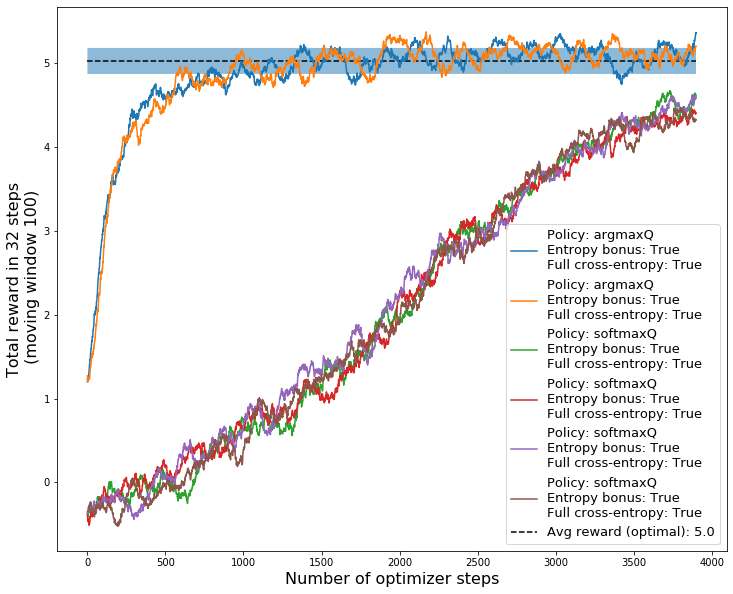

In [7]:
# Plot reward history of each run together with a legend to identify them and an horizontal line 
# (+ a confidence region) for the reward obtained by the optimal policy
window = 100

plt.figure(figsize=(12,10))
for i,d in enumerate(list_of_exp_dictionaries):
    total_rewards = d["total_rewards"]
    average_rewards = np.array([np.mean(total_rewards[i-window:i]) for i in range(window, len(total_rewards))])
    T = d["training_params"]["temperature"]
    entropy_bonus = d["training_params"]["entropy_bonus"]
    full_cross_ent = d["training_params"]["full_cross_entropy"]
    if T==0:
        label = "Policy: argmaxQ \nEntropy bonus: %s \nFull cross-entropy: %s"%(entropy_bonus,full_cross_ent)
    else:
        label = "Policy: softmaxQ \nEntropy bonus: %s \nFull cross-entropy: %s"%(entropy_bonus,full_cross_ent)
    plt.plot(np.arange(len(average_rewards)), average_rewards, label=label)
plt.hlines(optimal_reward_mean, 0, len(average_rewards), linestyles="dashed", 
           label="Avg reward (optimal): %.1f"%optimal_reward_mean)
plt.fill_between(np.arange(len(average_rewards)), 
                 optimal_reward_mean-optimal_reward_std/np.sqrt(window), 
                 optimal_reward_mean+optimal_reward_std/np.sqrt(window),
                 alpha=0.5)
plt.xlabel("Number of optimizer steps", fontsize=16)
plt.ylabel("Total reward in 32 steps\n (moving window %s)"%window, fontsize=16)
plt.legend(fontsize=13)
plt.show()

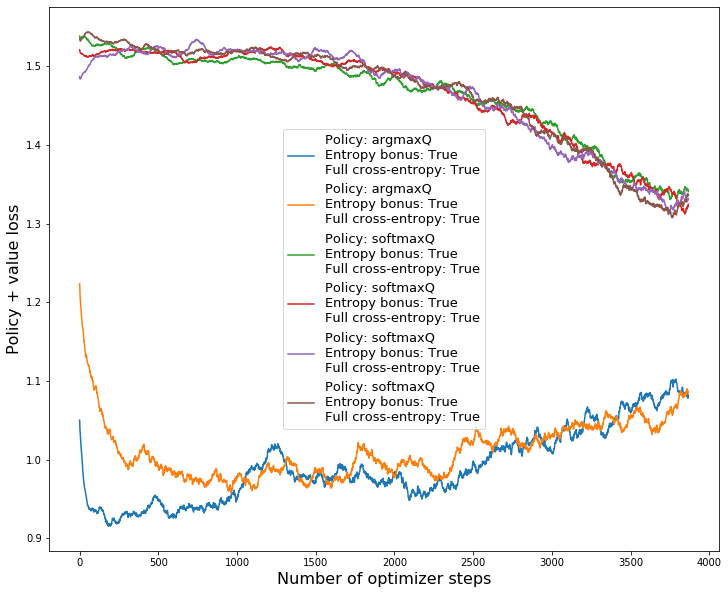

In [8]:
### Total Loss ###
window = 100

plt.figure(figsize=(12,10))
for i,d in enumerate(list_of_exp_dictionaries):
    losses = d["losses"]
    average_losses = np.array([np.mean(losses[i-window:i]) for i in range(window, len(losses))])
    T = d["training_params"]["temperature"]
    entropy_bonus = d["training_params"]["entropy_bonus"]
    full_cross_ent = d["training_params"]["full_cross_entropy"]
    if T==0:
        label = "Policy: argmaxQ \nEntropy bonus: %s \nFull cross-entropy: %s"%(entropy_bonus,full_cross_ent)
    else:
        label = "Policy: softmaxQ \nEntropy bonus: %s \nFull cross-entropy: %s"%(entropy_bonus,full_cross_ent)
    plt.plot(np.arange(len(average_losses)), average_losses, label=label)
plt.xlabel("Number of optimizer steps", fontsize=16)
plt.ylabel("Policy + value loss", fontsize=16)
plt.legend(fontsize=13)
plt.show()

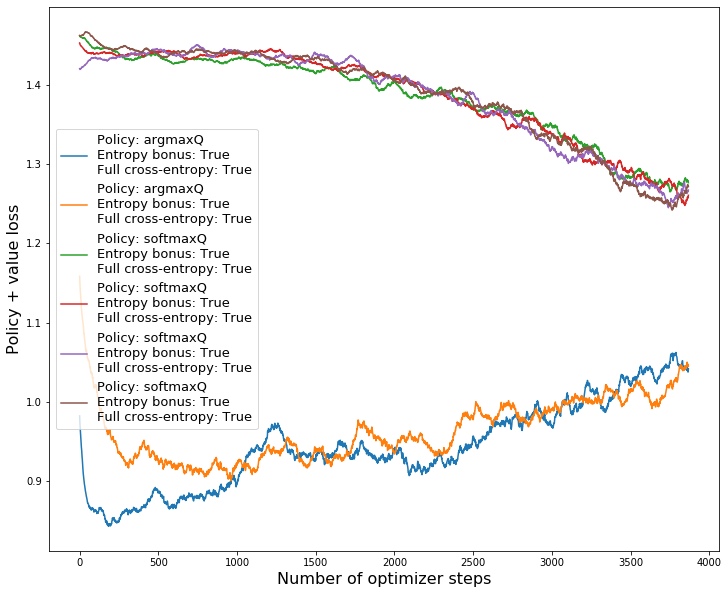

In [9]:
### Policy Loss ###
window = 100

plt.figure(figsize=(12,10))
for i,d in enumerate(list_of_exp_dictionaries):
    losses = d["policy_losses"]
    average_losses = np.array([np.mean(losses[i-window:i]) for i in range(window, len(losses))])
    T = d["training_params"]["temperature"]
    entropy_bonus = d["training_params"]["entropy_bonus"]
    full_cross_ent = d["training_params"]["full_cross_entropy"]
    if T==0:
        label = "Policy: argmaxQ \nEntropy bonus: %s \nFull cross-entropy: %s"%(entropy_bonus,full_cross_ent)
    else:
        label = "Policy: softmaxQ \nEntropy bonus: %s \nFull cross-entropy: %s"%(entropy_bonus,full_cross_ent)
    plt.plot(np.arange(len(average_losses)), average_losses, label=label)
plt.xlabel("Number of optimizer steps", fontsize=16)
plt.ylabel("Policy + value loss", fontsize=16)
plt.legend(fontsize=13)
plt.show()

Comment: the magnitude of the policy loss is much higher than the one of the value loss, but the 2 are optimized together. Is there any problem with it?

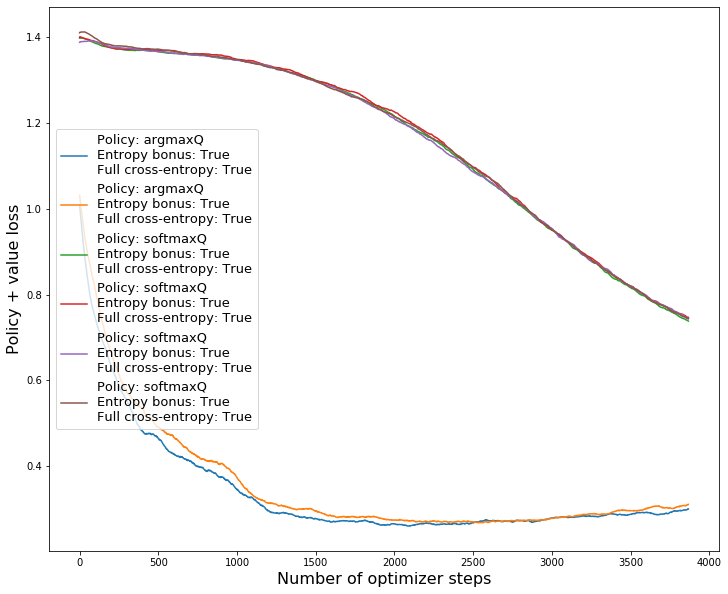

In [10]:
### Policy Entropy ###
window = 100

plt.figure(figsize=(12,10))
for i,d in enumerate(list_of_exp_dictionaries):
    losses = d["entropies"]
    average_losses = np.array([np.mean(losses[i-window:i]) for i in range(window, len(losses))])
    T = d["training_params"]["temperature"]
    entropy_bonus = d["training_params"]["entropy_bonus"]
    full_cross_ent = d["training_params"]["full_cross_entropy"]
    if T==0:
        label = "Policy: argmaxQ \nEntropy bonus: %s \nFull cross-entropy: %s"%(entropy_bonus,full_cross_ent)
    else:
        label = "Policy: softmaxQ \nEntropy bonus: %s \nFull cross-entropy: %s"%(entropy_bonus,full_cross_ent)
    plt.plot(np.arange(len(average_losses)), average_losses, label=label)
plt.xlabel("Number of optimizer steps", fontsize=16)
plt.ylabel("Policy + value loss", fontsize=16)
plt.legend(fontsize=13)
plt.show()

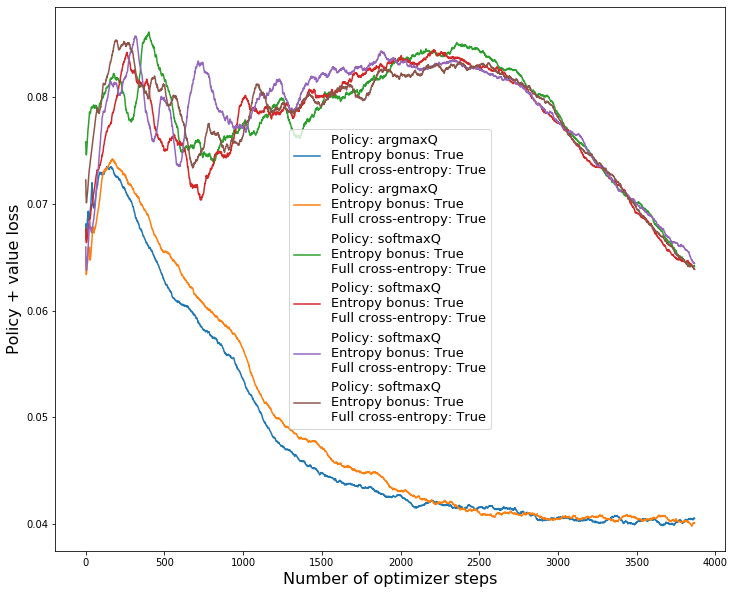

In [11]:
### Value Loss ###
window = 100

plt.figure(figsize=(12,10))
for i,d in enumerate(list_of_exp_dictionaries):
    losses = d["value_losses"]
    average_losses = np.array([np.mean(losses[i-window:i]) for i in range(window, len(losses))])
    T = d["training_params"]["temperature"]
    entropy_bonus = d["training_params"]["entropy_bonus"]
    full_cross_ent = d["training_params"]["full_cross_entropy"]
    if T==0:
        label = "Policy: argmaxQ \nEntropy bonus: %s \nFull cross-entropy: %s"%(entropy_bonus,full_cross_ent)
    else:
        label = "Policy: softmaxQ \nEntropy bonus: %s \nFull cross-entropy: %s"%(entropy_bonus,full_cross_ent)
    plt.plot(np.arange(len(average_losses)), average_losses, label=label)
plt.xlabel("Number of optimizer steps", fontsize=16)
plt.ylabel("Policy + value loss", fontsize=16)
plt.legend(fontsize=13)
plt.show()

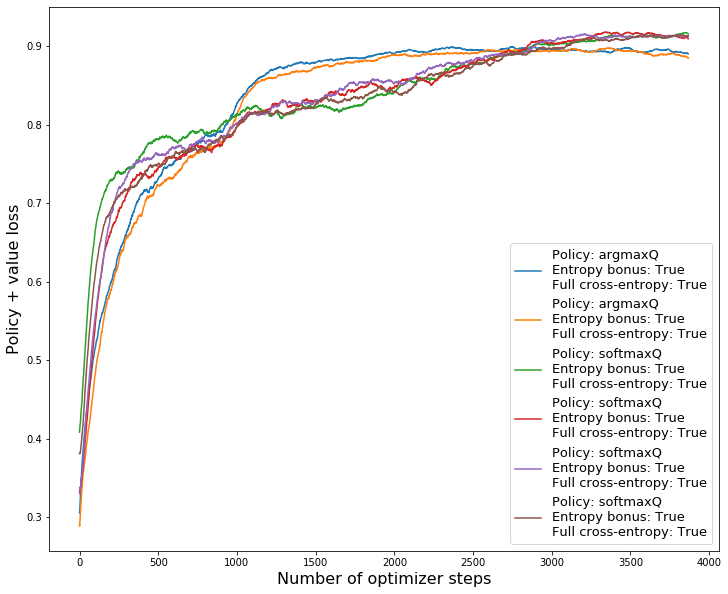

In [12]:
### Accuracy in predicting optimal actions ###
window = 100

plt.figure(figsize=(12,10))
for i,d in enumerate(list_of_exp_dictionaries):
    losses = d["accuracies"]
    average_losses = np.array([np.mean(losses[i-window:i]) for i in range(window, len(losses))])
    T = d["training_params"]["temperature"]
    entropy_bonus = d["training_params"]["entropy_bonus"]
    full_cross_ent = d["training_params"]["full_cross_entropy"]
    if T==0:
        label = "Policy: argmaxQ \nEntropy bonus: %s \nFull cross-entropy: %s"%(entropy_bonus,full_cross_ent)
    else:
        label = "Policy: softmaxQ \nEntropy bonus: %s \nFull cross-entropy: %s"%(entropy_bonus,full_cross_ent)
    plt.plot(np.arange(len(average_losses)), average_losses, label=label)
plt.xlabel("Number of optimizer steps", fontsize=16)
plt.ylabel("Policy + value loss", fontsize=16)
plt.legend(fontsize=13)
plt.show()

In [14]:
# Look at one episode played by each of the runs and at the summary of the MCTS root node 
# How is the action distribution wrt to prior? If we assign probability equal to the relative frequency 
# with wich each action has been selected during the search, how does the resulting policy compares to 
# the root prior? (entropy, probability of most probable action, ...)
for i,d in enumerate(list_of_exp_dictionaries):
    print("Episode from ID %s: "%exp_IDs[i])
    T = d["training_params"]["temperature"]
    entropy_bonus = d["training_params"]["entropy_bonus"]
    full_cross_ent = d["training_params"]["full_cross_entropy"]
    if T==0:
        label = "Policy: argmaxQ \nEntropy bonus: %s \nFull cross-entropy: %s"%(entropy_bonus,full_cross_ent)
    else:
        label = "Policy: softmaxQ \nEntropy bonus: %s \nFull cross-entropy: %s"%(entropy_bonus,full_cross_ent)
    print(label)
    pv_net = d["pv_net"]
    game_params = d["training_params"]
    
    results = train.play_episode_policy_value_net_v2(
        pv_net,
        game_simulator,
        game_params["episode_length"],
        game_params["ucb_C"],
        game_params["discount"],
        game_params["max_actions"],
        game_params["num_simulations"],
        object_ids,
        mode="predict",
        dir_noise=True,
        render = True
    )
    total_reward, frame_lst, reward_lst, done_lst, action_is_optimal, prior_is_optimal = results
    print("Prior is optimal in %.1f of cases."%(np.mean(prior_is_optimal)*100))
    print("MCTS is optimal in %.1f of cases."%(np.mean(action_is_optimal)*100))
    print("-"*40)
    print()

Episode from ID IPUX: 
Policy: argmaxQ 
Entropy bonus: True 
Full cross-entropy: True

██████
█!   █
█?n  █
█@y  █
█    █
██████

Action  Stay : Prior=0.002 - Q-value=0.000 - Visit counts=0
Action  Up : Prior=0.000 - Q-value=0.000 - Visit counts=0
Action  Down : Prior=0.001 - Q-value=0.528 - Visit counts=1
Action  Right : Prior=0.997 - Q-value=0.581 - Visit counts=49
Action with best prior:  4 (Right)
Action selected from MCTS:  4 (Right)
Best actions:  [4] ['Right']

██████
█!   █
█?n  █
█ @  █
█    █
██████
blessed sword
Reward received:  0
Done:  False
Action  Stay : Prior=0.008 - Q-value=0.000 - Visit counts=0
Action  Up : Prior=0.018 - Q-value=0.000 - Visit counts=0
Action  Down : Prior=0.052 - Q-value=0.000 - Visit counts=0
Action  Left : Prior=0.014 - Q-value=0.643 - Visit counts=1
Action  Right : Prior=0.908 - Q-value=0.650 - Visit counts=97
Action with best prior:  4 (Right)
Action selected from MCTS:  4 (Right)
Best actions:  [0] ['Stay']

██████
█!   █
█?n  █
█  @ █
█    █
█

Action  Stay : Prior=0.056 - Q-value=0.000 - Visit counts=0
Action  Up : Prior=0.043 - Q-value=0.615 - Visit counts=3
Action  Down : Prior=0.095 - Q-value=0.000 - Visit counts=0
Action  Left : Prior=0.048 - Q-value=0.000 - Visit counts=0
Action  Right : Prior=0.759 - Q-value=0.799 - Visit counts=47
Action with best prior:  4 (Right)
Action selected from MCTS:  4 (Right)
Best actions:  [4] ['Right']

██████
█   !█
█  @y█
█    █
█  ? █
██████
gleaming sword
Reward received:  0
Done:  False
Action  Stay : Prior=0.054 - Q-value=0.000 - Visit counts=0
Action  Up : Prior=0.059 - Q-value=0.000 - Visit counts=0
Action  Down : Prior=0.036 - Q-value=0.000 - Visit counts=0
Action  Left : Prior=0.052 - Q-value=0.000 - Visit counts=0
Action  Right : Prior=0.798 - Q-value=0.895 - Visit counts=96
Action with best prior:  4 (Right)
Action selected from MCTS:  4 (Right)
Best actions:  [4] ['Right']

██████
█   !█
█   @█
█    █
█  ? █
██████
blessed sword
Reward received:  0
Done:  False
Action  Stay : 

In [14]:
# Try to spot if there is any line in the code justifying the differences in time elapsed 
# for the different models

# Old experiments

In [2]:
load_dir = "./save_dir"
all_dirs = os.listdir(load_dir)
print("all_dirs: ", all_dirs)
paths_to_load = []
experiment_ids = []
for f in all_dirs:
    print("\nAccessing directory %s"%f)
    all_checkpoints = os.listdir(load_dir+"/%s/"%f)
    print(all_checkpoints)
    if len(all_checkpoints) > 0:
        for c in all_checkpoints:
            if "training_dict" in c:
                print(c)
        print("Last checkpoint: ", c)
        paths_to_load.append(load_dir+"/%s/%s"%(f,c))
        experiment_ids.append(f)
print("paths to load: ", paths_to_load)
print("experiment_ids: ", experiment_ids)

all_dirs:  ['AAA', 'AAB', '.ipynb_checkpoints', 'AAC', 'policy_AAA', 'MMOV', 'UCJP', 'ARPH', 'ATJN', 'CEZN', 'CLUO', 'CTCD', 'CVPS', 'DCSQ', 'FMAQ', 'GSCU', 'GWVZ', 'HULL', 'IBMB', 'IWSF', 'JCAN', 'JUWQ', 'JZIN', 'KRXY', 'LQEC', 'LSDV', 'MERZ', 'OJEI', 'QGCK', 'SDGK', 'SZTK', 'UGDZ', 'WEOU', 'WJHE', 'WLXF', 'XJNO', 'XYDM', 'YLUP', 'YOAV', 'AAD']

Accessing directory AAA
['.ipynb_checkpoints', 'training_dict_100', 'training_dict_200', 'training_dict_300', 'training_dict_400', 'training_dict_500', 'training_dict_600', 'training_dict_700', 'training_dict_800', 'training_dict_900', 'training_dict_1000', 'training_dict_1100', 'training_dict_1200', 'training_dict_1300', 'training_dict_1400', 'training_dict_1500', 'training_dict_1600', 'training_dict_1700', 'training_dict_1800', 'training_dict_1900', 'training_dict_2000']
training_dict_100
training_dict_200
training_dict_300
training_dict_400
training_dict_500
training_dict_600
training_dict_700
training_dict_800
training_dict_900
training_di

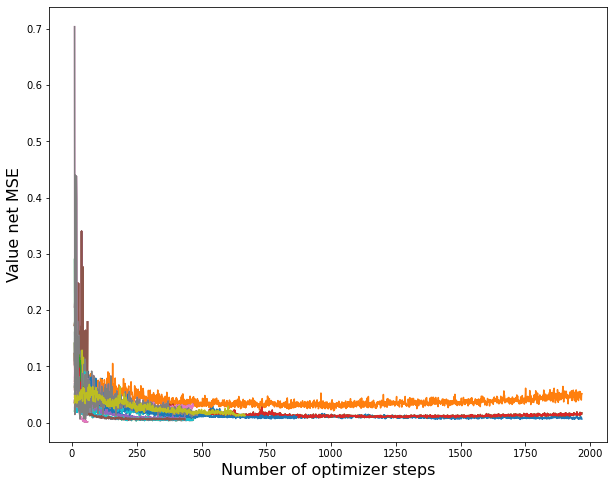

In [3]:
plt.figure(figsize=(10,8))
for i, path in enumerate(paths_to_load):
    try:
        training_dict = torch.load(path)
        object_ids = training_dict["object_ids"]
        value_net = training_dict["value_net"]
        target_net = training_dict["target_net"]
        rb = training_dict["rb"]
        losses = training_dict["losses"]
        episodes_played = training_dict["episodes_played"]
        training_params = training_dict["training_params"]
        total_rewards = training_dict["total_rewards"]
        n_steps = training_params["n_steps"]
    except:
        pass
    
    plt.plot(np.arange(len(losses))[10:], losses[10:], label="%s"%experiment_ids[i])
plt.xlabel("Number of optimizer steps", fontsize=16)
plt.ylabel("Value net MSE", fontsize=16)
plt.show()

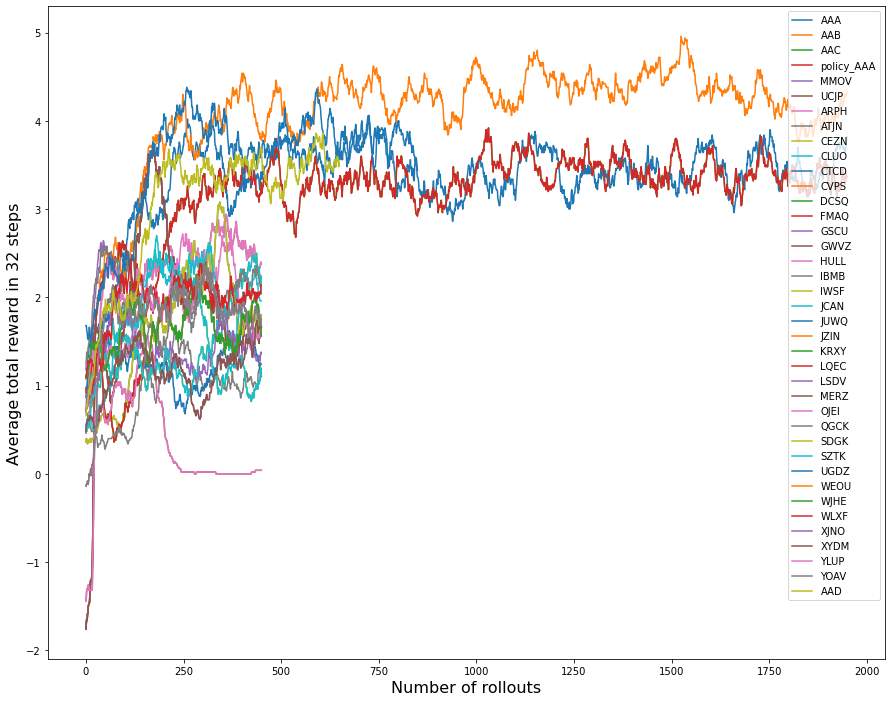

In [5]:
plt.figure(figsize=(15,12))
for i, path in enumerate(paths_to_load):
    try:
        training_dict = torch.load(path)
        object_ids = training_dict["object_ids"]
        value_net = training_dict["value_net"]
        target_net = training_dict["target_net"]
        rb = training_dict["rb"]
        losses = training_dict["losses"]
        episodes_played = training_dict["episodes_played"]
        training_params = training_dict["training_params"]
        total_rewards = training_dict["total_rewards"]
        n_steps = training_params["n_steps"]
    except:
        pass

    window = 50
    average_rewards = np.array([np.mean(total_rewards[i-window:i]) for i in range(window, len(total_rewards))])
    plt.plot(np.arange(len(average_rewards)), average_rewards, label="%s"%experiment_ids[i])
plt.xlabel("Number of rollouts", fontsize=16)
plt.ylabel("Average total reward in 32 steps", fontsize=16)
plt.legend()
plt.show()